# Sanity check for hypothesis testing

Model trained with KO gene has labels and tested between guides that knock out the same gene.

### Imports

In [1]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp
from scipy.stats import ttest_ind, wasserstein_distance, ks_2samp
from scipy.stats import norm

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

In [19]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.variance as vr
import scvi_extensions.dataset.label_data_loader as ldl

### Load the model

In [34]:
model = torch.load('/Users/mincheolkim/Documents/vaec_model_vargenes.model', map_location=lambda storage, loc: storage)

### Create the dataset with guides as labels

In [35]:
h5_filename = data_path + 'raw_gene_bc_matrices_h5.h5'
metadata_filename = data_path + 'nsnp20.raw.sng.km_vb1.norm.meta.txt'

In [36]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='guide',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 283634
Number of cells kept after removing all zero cells: 283634
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


### Find the indices for the two BATF guide labels and two normal guide labels

In [37]:
pd.Series(gene_dataset.guide_lookup)[pd.Series(gene_dataset.guide_lookup).str.contains('BATF')]

16    BATF.75522739.AGGACTCTACCTGTTTGCCA_guide
17    BATF.75546499.ACAGAACGCGGCTCTACGCA_guide
dtype: object

In [38]:
pd.Series(gene_dataset.guide_lookup)[pd.Series(gene_dataset.guide_lookup).str.contains('NO_GUIDE')]

156    NO_GUIDE
dtype: object

### Variance testing

Test between BATF guide 1, BATF guide 2, and NO_GUIDE

In [66]:
variance_results = vr.gene_variance_test(model, gene_dataset, [16, 17, 156], 100, 10000)

Sampling for variance testing...
Done sampling for variance testing...


In [67]:
variance_results[16][17].head(3)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
983,DDX3X,983,0.4356,-0.259039,0.259039,3.215393e-32,-1.0
169,CCL4,169,0.4369,-0.253753,0.253753,5.474692e-31,-1.0
678,RAP1A,678,0.4374,-0.251721,0.251721,1.603816e-30,-1.0


In [68]:
variance_results[16][156].head(3)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
624,LYAR,624,0.3546,-0.598880,0.598880,7.957008e-159,-1.0
617,CD59,617,0.3623,-0.565395,0.565395,1.470970e-142,-1.0
255,IL2RG,255,0.3749,-0.511252,0.511252,7.361522e-118,-1.0


/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Variance P(H1) Distribution')

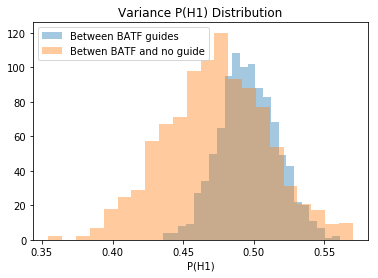

In [72]:
sns.distplot(variance_results[16][17]['P(H1)'], kde=False)
sns.distplot(variance_results[16][156]['P(H1)'], kde=False)
plt.legend(['Between BATF guides', 'Betwen BATF and no guide'])
plt.title('Variance P(H1) Distribution')

### Differential Expression

In [60]:
de_results = mn.differential_expression(model, gene_dataset, [16, 17, 156], 100, 10000)

Sampling for differential expression...
Done sampling for differential expression...


In [61]:
de_results[16][17].head(3)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
352,HIGD2A,352,0.5746,0.300644,0.300644,0.000000e+00,1.0
501,SELK,501,0.4359,-0.257819,0.257819,3.310408e-48,-1.0
763,SPCS3,763,0.4375,-0.251314,0.251314,6.844732e-46,-1.0


In [63]:
de_results[16][156].head(3)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
624,LYAR,624,0.3668,-0.545970,0.545970,1.184358e-204,-1.0
659,SEC11A,659,0.3727,-0.520651,0.520651,5.550273e-187,-1.0
683,LIMS1,683,0.3730,-0.519368,0.519368,4.181235e-186,-1.0


/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'DE P(H1) Distribution')

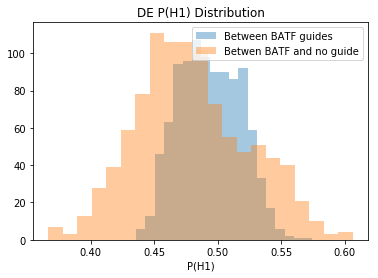

In [71]:
sns.distplot(de_results[16][17]['P(H1)'], kde=False)
sns.distplot(de_results[16][156]['P(H1)'], kde=False)
plt.legend(['Between BATF guides', 'Betwen BATF and no guide'])
plt.title('DE P(H1) Distribution')